In [30]:
import pyddm
from pyddm import Model
from pyddm.models.loss import LossLikelihood
from pyddm.plot import plot_fit_diagnostics
import pandas as pd
import numpy as np
pyddm.functions.set_N_cpus(1)

import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Scaling constant - models are identified only up to a scaling constant

For further reading about this topic, see:
- Donkin, C., Brown, S. D., & Heathcote, A. (2009). The overconstraint of response time models: Rethinking the scaling problem. Psychonomic Bulletin & Review, 16(6), 1129–1135. https://doi.org/10.3758/PBR.16.6.1129

- Van Maanen, L., & Miletić, S. (2021). The interpretation of behavior-model correlations in unidentified cognitive models. Psychonomic Bulletin & Review, 28(2), 374–383. https://doi.org/10.3758/s13423-020-01783-y


## Let's simulate some data

In [31]:
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision
true_params = {
    "drift": 0.4,
    "boundary": 1.0,
    "noise": 1.0,
    "ndt": 0.3
}

model_true = Model(
    drift=DriftConstant(drift=true_params["drift"]),
    noise=NoiseConstant(noise=true_params["noise"]),
    bound=BoundConstant(B=true_params["boundary"]),
    overlay=OverlayNonDecision(nondectime=true_params["ndt"]),
    dx=.005, dt=.005, T_dur=10
)

sim_data = model_true.solve().resample(10000)   # generate 10000 RTs

1.2586812334302055
0.6871


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


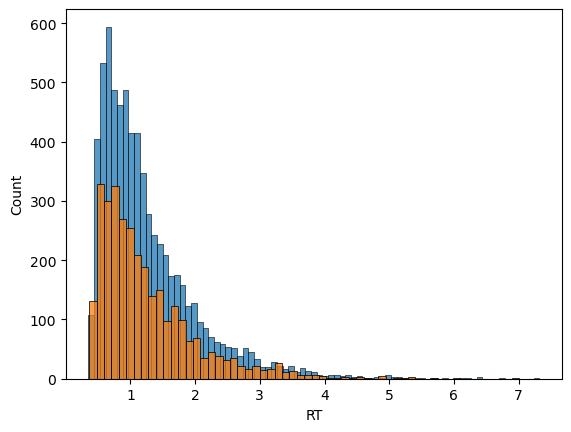

In [32]:
df = sim_data.to_pandas_dataframe()

sns.histplot(df.loc[df['choice']==1, 'RT'])
sns.histplot(df.loc[df['choice']==0, 'RT'])

## also get the mean RT and accuracy
print(df.RT.mean())
print(df.choice.mean())

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


1.258100687264523
0.6869


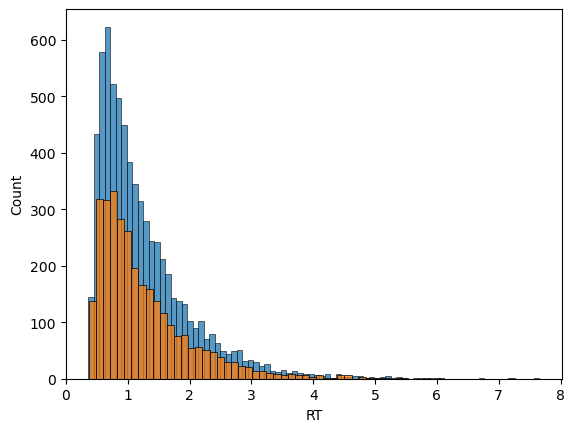

In [33]:
## Now, let's simulate a second dataset, with the following parameters (notice their relation with the true parameters)

new_params = {
    "drift": 0.8,
    "boundary": 2.0,
    "noise": 2.0,
    "ndt": 0.3
}

model_new = Model(
    drift=DriftConstant(drift=new_params["drift"]),
    noise=NoiseConstant(noise=new_params["noise"]),
    bound=BoundConstant(B=new_params["boundary"]),
    overlay=OverlayNonDecision(nondectime=new_params["ndt"]),
    dx=.005, dt=.005, T_dur=10
)

sim_data_new = model_new.solve().resample(10000)   # generate 10000 RTs


df_new = sim_data_new.to_pandas_dataframe()

sns.histplot(df_new.loc[df_new['choice']==1, 'RT'])
sns.histplot(df_new.loc[df_new['choice']==0, 'RT'])
## also get the mean RT and accuracy
print(df_new.RT.mean())
print(df_new.choice.mean())

### What do you notice?

Another way of looking at the same problem: Take `df`, and calculate the likelihood of both `true_pars` and `new_pars`

In [34]:
print(LossLikelihood(sample=sim_data_new, dt=0.005, T_dur=10).loss(model_true))
print(LossLikelihood(sample=sim_data_new, dt=0.005, T_dur=10).loss(model_new))

14464.518934373546
14464.518934373546


#### So the simulated data is equally likely under both sets of parameters. This is known as unidentifiability: There is not one unique set of best parameters to describe the data.

Cognitive models like the DDM are only identified up to a scaling constant. That is, one decision-related parameter (e.g., drift rate, diffusion constant, threshold -- the scaling constant) *must* be set to a fixed value, and then all the *other* parameters are identified.

If we don't do this, we can find many different "best" parameter sets.

The convention is to set the diffusion constant (within-trial noise) to 1 as a scaling parameter, as follows:

In [35]:
noise_fixed = NoiseConstant(noise=1.0)

model_to_fit = Model(
    drift=DriftConstant(drift=pyddm.Fittable(minval=0.01, maxval=3)),
    noise=noise_fixed,
    bound=BoundConstant(B=pyddm.Fittable(minval=.3, maxval=3)),
    overlay=OverlayNonDecision(nondectime=pyddm.Fittable(minval=.0, maxval=.6)),
    dx=.005, dt=.005, T_dur=15.0)

model_to_fit.fit(sample=sim_data, verbose=False)
model_to_fit.parameters()

Info: Params [0.3909457  0.99634572 0.30812414] gave 14525.231871505646


{'drift': {'drift': Fitted(0.39094569774090515, minval=0.01, maxval=3)},
 'noise': {'noise': 1.0},
 'bound': {'B': Fitted(0.9963457244815891, minval=0.3, maxval=3)},
 'IC': {},
 'overlay': {'nondectime': Fitted(0.3081241401080284, minval=0.0, maxval=0.6)}}

In [36]:
## If I re-fit the same model, I get back the same parameters (barring esitmation noise):

noise_fixed = NoiseConstant(noise=1.0)

model_to_fit2 = Model(
    drift=DriftConstant(drift=pyddm.Fittable(minval=0.01, maxval=3)),
    noise=noise_fixed,
    bound=BoundConstant(B=pyddm.Fittable(minval=.3, maxval=3)),
    overlay=OverlayNonDecision(nondectime=pyddm.Fittable(minval=.0, maxval=.6)),
    dx=.005, dt=.005, T_dur=15.0)

model_to_fit2.fit(sample=sim_data, verbose=False)
model_to_fit2.parameters()

Info: Params [0.3911955  1.01265963 0.29392217] gave 14522.575827508654


{'drift': {'drift': Fitted(0.3911955013571743, minval=0.01, maxval=3)},
 'noise': {'noise': 1.0},
 'bound': {'B': Fitted(1.0126596274057487, minval=0.3, maxval=3)},
 'IC': {},
 'overlay': {'nondectime': Fitted(0.29392216614962147, minval=0.0, maxval=0.6)}}

# 2. Fit per participant, not across the entire dataset

Each participant's behavior is different, and has a different set of parameters compared to the others. If we fit a single model to all RTs and choices in one go, we are ignoring individual differences. This is wrong and can lead to wrong inferences.

In [37]:
participants = [
    {"id": 1, "drift": 0.4, "boundary": 1.0, "ndt": 0.30},
    {"id": 2, "drift": 0.8, "boundary": 0.7, "ndt": 0.20},
    {"id": 3, "drift": 0.2, "boundary": 1.3, "ndt": 0.33},
]

dfs = []
for p in participants:
    model = Model(
        drift=DriftConstant(drift=p["drift"]),
        noise=NoiseConstant(noise=1.0),
        bound=BoundConstant(B=p["boundary"]),
        overlay=OverlayNonDecision(nondectime=p["ndt"]),
        dx=.005, dt=.005, T_dur=15.0,
    )
    sim_data = model.solve().resample(2000)
    df = sim_data.to_pandas_dataframe() #({"rt": sim_data.t, "choice": sim_data.c})
    df["participant"] = p["id"]
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


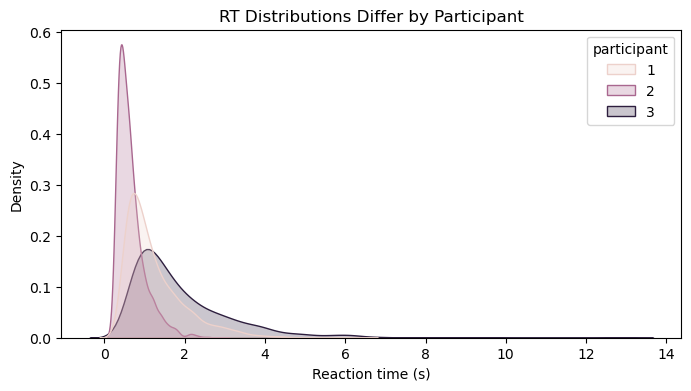

In [38]:
plt.figure(figsize=(8,4))
sns.kdeplot(data=df_all, x="RT", hue="participant", fill=True)
plt.title("RT Distributions Differ by Participant")
plt.xlabel("Reaction time (s)")
plt.show()

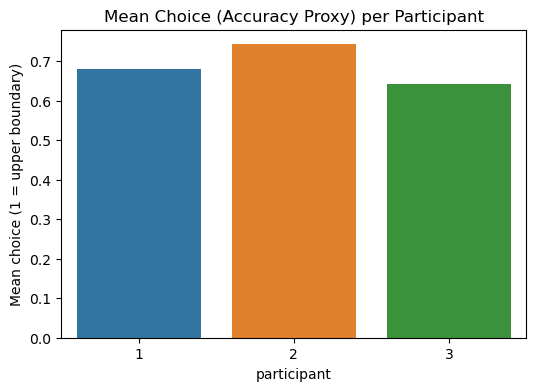

In [39]:
acc = df_all.groupby("participant")["choice"].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=acc.index, y=acc.values)
plt.title("Mean Choice (Accuracy Proxy) per Participant")
plt.ylabel("Mean choice (1 = upper boundary)")
plt.show()

### What happens if we fit one model to the concatenated data?

In [40]:
model_pooled = Model(
    drift=DriftConstant(drift=pyddm.Fittable(minval=0.01, maxval=2)),
    noise=NoiseConstant(noise=1.0),
    bound=BoundConstant(B=pyddm.Fittable(minval=0.3, maxval=2)),
    overlay=OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=0.5)),
    dx=.005, dt=.005, T_dur=15.0,
)

model_pooled.fit(pyddm.Sample.from_pandas_dataframe(df_all, rt_column_name='RT', choice_column_name='choice'),verbose=False)

Info: Params [0.36307258 1.08328802 0.1371895 ] gave 9663.936779941017


In [41]:
print('Pooled parameters: ')
model_pooled.parameters()

Pooled parameters: 


{'drift': {'drift': Fitted(0.3630725843442245, minval=0.01, maxval=2)},
 'noise': {'noise': 1.0},
 'bound': {'B': Fitted(1.0832880189798115, minval=0.3, maxval=2)},
 'IC': {},
 'overlay': {'nondectime': Fitted(0.13718949621318377, minval=0, maxval=0.5)}}

In [42]:
print('True mean parameters')
pd.DataFrame(participants).mean()

# note how far off the drift rate and non-decision time are!

True mean parameters


id          2.000000
drift       0.466667
boundary    1.000000
ndt         0.276667
dtype: float64

In [43]:
## The correct way is to fit a model *per participant separately*
fits_individual = {}

for pid in df_all["participant"].unique():
    df_p = df_all[df_all["participant"] == pid]
    
    model_i = Model(
        drift=DriftConstant(drift=pyddm.Fittable(minval=0.01, maxval=2)),
        noise=NoiseConstant(noise=1.0),
        bound=BoundConstant(B=pyddm.Fittable(minval=0.3, maxval=2)),
        overlay=OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=0.5)),
        dx=.005, dt=.005, T_dur=15.0,
    )
    
    model_i.fit(sample=pyddm.Sample.from_pandas_dataframe(df_p, rt_column_name='RT', choice_column_name='choice'), verbose=False)
    fits_individual[pid] = model_i.parameters()

fits_individual

Info: Params [0.37942135 1.00051715 0.29915411] gave 2872.4463920297712
Info: Params [0.75740764 0.69883723 0.20705388] gave 1266.7902767219125
Info: Params [0.23298528 1.25872373 0.34354499] gave 3915.6547235377384


{1: {'drift': {'drift': Fitted(0.37942134724066323, minval=0.01, maxval=2)},
  'noise': {'noise': 1.0},
  'bound': {'B': Fitted(1.0005171537701796, minval=0.3, maxval=2)},
  'IC': {},
  'overlay': {'nondectime': Fitted(0.2991541089344313, minval=0, maxval=0.5)}},
 2: {'drift': {'drift': Fitted(0.7574076359811243, minval=0.01, maxval=2)},
  'noise': {'noise': 1.0},
  'bound': {'B': Fitted(0.698837234839491, minval=0.3, maxval=2)},
  'IC': {},
  'overlay': {'nondectime': Fitted(0.20705388426389698, minval=0, maxval=0.5)}},
 3: {'drift': {'drift': Fitted(0.23298527871452582, minval=0.01, maxval=2)},
  'noise': {'noise': 1.0},
  'bound': {'B': Fitted(1.2587237250085805, minval=0.3, maxval=2)},
  'IC': {},
  'overlay': {'nondectime': Fitted(0.3435449897053231, minval=0, maxval=0.5)}}}

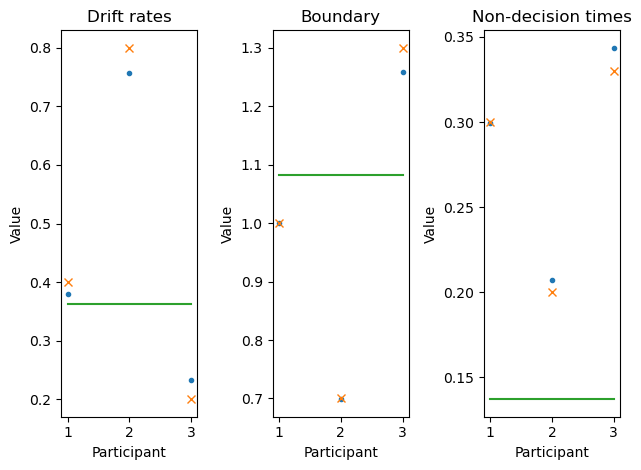

In [44]:
f, ax = plt.subplots(1,3)

## plot fitted parameters by subject
ax[0].plot(np.arange(1,4), [x['drift']['drift'] for x in fits_individual.values()], '.')
ax[1].plot(np.arange(1,4), [x['bound']['B'] for x in fits_individual.values()], '.')
ax[2].plot(np.arange(1,4), [x['overlay']['nondectime'] for x in fits_individual.values()], '.')

## plot true parameters
ax[0].plot(np.arange(1,4), [x['drift'] for x in participants], 'x')
ax[1].plot(np.arange(1,4), [x['boundary'] for x in participants], 'x')
ax[2].plot(np.arange(1,4), [x['ndt'] for x in participants], 'x')

## plot "pooled" parameters as line
ax[0].plot(np.arange(1,4), [model_pooled.parameters()['drift']['drift'] for x in range(len(participants))], '-')
ax[1].plot(np.arange(1,4), [model_pooled.parameters()['bound']['B'] for x in range(len(participants))], '-')
ax[2].plot(np.arange(1,4), [model_pooled.parameters()['overlay']['nondectime'] for x in range(len(participants))], '-')

ax[0].set_title('Drift rates')
ax[1].set_title('Boundary')
ax[2].set_title('Non-decision times')

ax[0].set_xlabel('Participant')
ax[1].set_xlabel('Participant')
ax[2].set_xlabel('Participant')

ax[0].set_ylabel('Value')
ax[1].set_ylabel('Value')
ax[2].set_ylabel('Value')

f.tight_layout()

# 3. Statistical tests

In all your datasets, there are two experimental conditions. How to go about testing which parameter differs between conditions? One option is to fit two models per participant (one for each condition), allowing all parameters to vary freely between the conditions.

In [45]:
# helper function
def flatten_params(params):
    flat = {}
    for comp, comp_params in params.items():
        if isinstance(comp_params, dict):
            for name, value in comp_params.items():
                flat[name] = value.value if hasattr(value, "value") else value
    return flat


In [46]:
np.random.seed(123)
participants = [1, 2, 3]
conditions = ["A", "B"]

dfs = []

for pid in participants:
    for cond in conditions:
        # Simulate some simple RT/choice data for illustration. This is just drawn rom an exponential distribution - a very bad choice for realistic data, but only used here to illustrate a point.
        df = pd.DataFrame({
            "rt": np.random.exponential(scale=0.5 + 0.1 * (cond=="B"), size=200)+0.2,
            "choice": np.random.choice([1, 0], size=200),
            "participant": pid,
            "condition": cond
        })
        dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

In [47]:
fits = {}

for pid in df_all["participant"].unique():
    fits[pid] = {}
    for cond in conditions:
        df_sub = df_all[(df_all["participant"]==pid) & (df_all["condition"]==cond)]
        
        model = Model(
            drift=DriftConstant(drift=pyddm.Fittable(minval=0.01, maxval=2)),
            noise=NoiseConstant(noise=1.0),
            bound=BoundConstant(B=pyddm.Fittable(minval=0.3, maxval=2)),
            overlay=OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=0.5)),
            dx=.005, dt=.005, T_dur=15
        )
        
        model.fit(sample=pyddm.Sample.from_pandas_dataframe(df_sub, rt_column_name='rt', choice_column_name='choice'), verbose=False)
        fits[pid][cond] = flatten_params(model.parameters())

Info: Params [0.01       0.73343048 0.13647912] gave 189.73374912005903
Info: Params [0.01       0.81300016 0.11415781] gave 241.37433116664977
Info: Params [0.09880971 0.79608375 0.12449312] gave 227.1165796103918
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
Info: Params [0.10161172 0.77752608 0.10999646] gave 217.3661435151887
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
Info: Params [0.01364644 0.80052184 0.11327951] gave 232.3087340771233
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
Info: Params [0.0796184  0.8312318  0.11343925] gave 243.8749464870828


In [48]:
rows = []

for pid, fit_dict in fits.items():
    row = {"participant": pid}
    for cond in conditions:
        for param, val in fit_dict[cond].items():
            row[f"{param}_{cond}"] = val
    rows.append(row)

df_params = pd.DataFrame(rows)
df_params

,participant,drift_A,noise_A,B_A,nondectime_A,drift_B,noise_B,B_B,nondectime_B
0,1,0.010000,1.0,0.733430,0.136479,0.010000,1.0,0.813000,0.114158
1,2,0.098810,1.0,0.796084,0.124493,0.101612,1.0,0.777526,0.109996
2,3,0.013646,1.0,0.800522,0.113280,0.079618,1.0,0.831232,0.113439


And now you can run a statistical test to discover which parameters differ between conditions. (In this simulated example, none!)

Additionally, you may want to plot the parameter values. Here's an ugly plot that you probably shouldn't use, but it hopefully illustrates that a plot can be very informative!

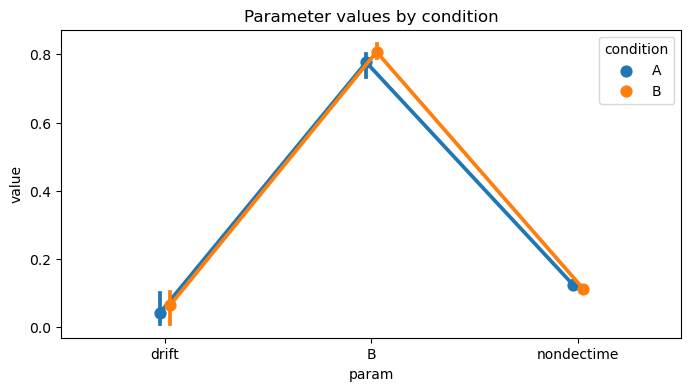

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

df_long = df_params.melt(
    id_vars=["participant"],
    value_vars=["drift_A","drift_B","B_A","B_B","nondectime_A","nondectime_B"],
    var_name="param_cond",
    value_name="value"
)

# Split param and condition
df_long["param"] = df_long["param_cond"].apply(lambda x: x.split("_")[0])
df_long["condition"] = df_long["param_cond"].apply(lambda x: x.split("_")[1])

plt.figure(figsize=(8,4))
sns.pointplot(data=df_long, x="param", y="value", hue="condition", dodge=True, markers="o")
plt.title("Parameter values by condition")
plt.show()


## The advanced/alternative option is to test a hypothesis by only allowing *only one* parameter to vary across conditions - while keeping the others constant

This is a quite elegant way of going about, because in this case, you can do formal model comparisons (e.g., BIC values) instead of a t-test. The idea is that you fit three (or more) models:
1. Model 1: Only the drift rate differs per condition, but the non-decision time, bound, start point, etc are the same across conditions
2. Model 2: Only the bound differs per condition, but the non-decision time, drift rate, start point, etc are the same across conditions
3. Model 3: Only the start point differs per condition, but the non-decision time, drift rate, bound, etc are the same across conditions

In this case, you end up with one BIC value per model per participant. BIC values *do not* need any statistical test anymore, they *are* statistical tests. So, for example, you could simply count the number of participants for which model 1 wins, and the number of participant for which models 2 and 3 win. Do *not* do a t-test to compare BIC values!

# 4. Visualizing fit

Because all participants are unique, you cannot meaningfully plot an entire RT distribution across all subjects. Returning to the example above:

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


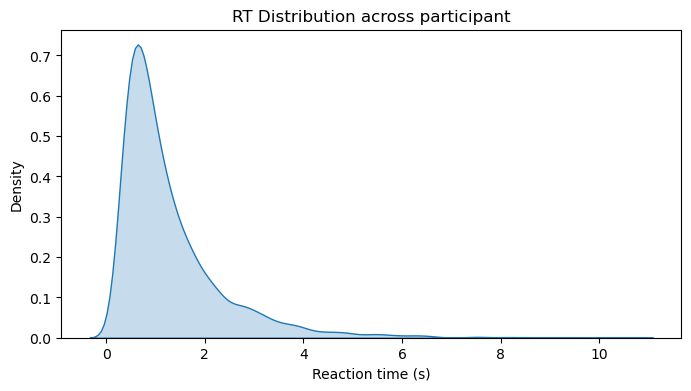

In [50]:
participants = [
    {"id": 1, "drift": 0.4, "boundary": 1.0, "ndt": 0.30},
    {"id": 2, "drift": 0.8, "boundary": 0.7, "ndt": 0.20},
    {"id": 3, "drift": 0.2, "boundary": 1.3, "ndt": 0.33},
]

dfs = []
for p in participants:
    model = Model(
        drift=DriftConstant(drift=p["drift"]),
        noise=NoiseConstant(noise=1.0),
        bound=BoundConstant(B=p["boundary"]),
        overlay=OverlayNonDecision(nondectime=p["ndt"]),
        dx=.005, dt=.005, T_dur=15.0,
    )
    sim_data = model.solve().resample(2000)
    df = sim_data.to_pandas_dataframe()
    df["participant"] = p["id"]
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(8,4))
sns.kdeplot(data=df_all, x="RT", fill=True)
plt.title("RT Distribution across participant")
plt.xlabel("Reaction time (s)")
plt.show()

This may look OK, but this visualization hides the fact that it's not one distribution but actually three separate ones with widely different shapes:

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


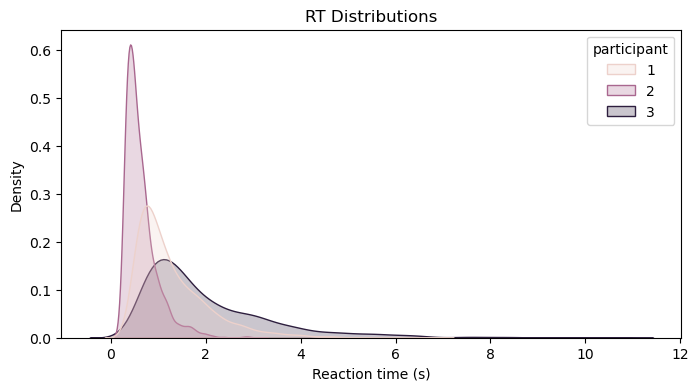

In [51]:
plt.figure(figsize=(8,4))
sns.kdeplot(data=df_all, x="RT", hue="participant", fill=True)
plt.title("RT Distributions")
plt.xlabel("Reaction time (s)")
plt.show()

The same issue arises when we visualize the quality of fit - so these should also be plotted separately for each participant and condition!

In [52]:
fits = {}

for pid in df_all["participant"].unique():
    df_p = df_all[df_all["participant"] == pid]
    
    model = Model(
        drift=DriftConstant(drift=pyddm.Fittable(minval=0.01, maxval=2)),
        noise=NoiseConstant(noise=1.0),
        bound=BoundConstant(B=pyddm.Fittable(minval=0.3, maxval=2)),
        overlay=OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=0.5)),
        dx=.005, dt=.005, T_dur=15.0
    )
    
    model.fit(sample=pyddm.Sample.from_pandas_dataframe(df_p, rt_column_name="RT", choice_column_name="choice"), verbose=False)
    fits[pid] = model

/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
Info: Params [0.38797009 1.0192879  0.30584463] gave 2910.692813843075
Info: Params [0.79787355 0.68033588 0.20962246] gave 1146.430809678418
Info: Params [0.18741956 1.30114944 0.33849424] gave 4084.323887429583


In [53]:
sim_preds = []

for pid, model_fitted in fits.items():
    df_p = df_all[df_all["participant"] == pid]
    
    # Use fitted parameters to generate predicted distribution
    sim = model_fitted.solve().resample(len(df_p))  # resample same number of trials
    df_sim = sim.to_pandas_dataframe()
    df_sim["participant"] = pid
    df_sim["type"] = "model"
    
    # Add empirical data for comparison
    df_emp = df_p.copy()
    df_emp["type"] = "data"
    
    sim_preds.append(pd.concat([df_emp, df_sim], ignore_index=True))

df_plot = pd.concat(sim_preds, ignore_index=True)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

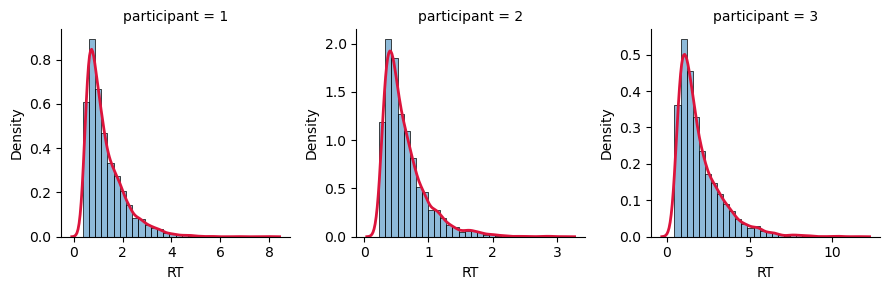

In [54]:
# Something like this might work
g = sns.FacetGrid(
    df_plot,
    col="participant",
    col_wrap=3,
    height=3,
    sharex=False,
    sharey=False
)

# Histograms for observed
g.map_dataframe(
    sns.histplot,
    x="RT",
    stat="density",
    bins=30,
    alpha=0.5,
    hue=None,   # don't split by type here
    data=lambda d: d[d["type"] == "observed"]
)

# KDE for predicted
g.map_dataframe(
    sns.kdeplot,
    x="RT",
    color="crimson",
    lw=2,
    data=lambda d: d[d["type"] == "predicted"]
)

# We're starting to get somewhere...
but we're not yet visualizing the RT distribution per choice option separately. Remember that the DDM is supposed to predict those shapes separately

Here's an example of how that could look for a single participant

In [55]:
from scipy.stats import gaussian_kde
def defective_kde(samples, xs, weight):
    """
    samples: 1D array of RT samples
    xs: grid on which KDE is evaluated
    weight: proportion of trials for this choice
    """
    kde = gaussian_kde(samples)
    ys = kde(xs) * weight
    return ys

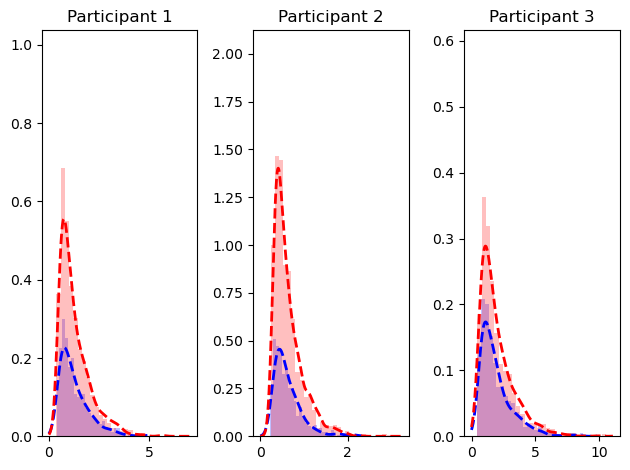

In [56]:

colors = {0: "blue", 1: "red"}

f, ax = plt.subplots(1,3)
for participant in [1,2,3]:
    sub = df_plot.loc[df_plot.participant==participant]
    for choice in [0,1]:
        dat_obs = sub.loc[(sub["choice"]==choice) & (sub["type"]=="data"), "RT"].values
        dat_pred = sub.loc[(sub["choice"]==choice) & (sub["type"]=="model"), "RT"].values
        
        # Compute defective weights PER PARTICIPANT
        w_obs = len(dat_obs)  / sub.loc[(sub["type"]=="data")].shape[0]
        w_pred = len(dat_pred) / sub.loc[(sub["type"]=="model")].shape[0]
        
        xs = np.linspace(0, dat_obs.max()*1.05, 400)
        
        ax[participant-1].hist(
            dat_obs,
            bins=30,
            density=True,
            alpha=0.25,
            color=colors[choice]
        )
        
        # Scale histogram heights by weight - make it defective!
        for patch in ax[participant-1].patches[-30:]:   # last histogram’s patches
            patch.set_height(patch.get_height() * w_obs)
        
        ys_pred = defective_kde(dat_pred, xs, w_pred)
        ax[participant-1].plot(xs, ys_pred, lw=2, linestyle='--', color=colors[choice])
    ax[participant-1].set_title(f'Participant {participant}')
f.tight_layout()

## Think about this: Why am I making these distributions "defective"?

You'll notice that this easily becomes a mess with 4 different plots per participant (RT distribution for accurate and error responses, for both conditions). So it'd be very useful to summarize all data

Info: Model(name='', drift=DriftConstant(drift=Fitted(1.011545417928745, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(0.31073442689283093, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.23478682460290543, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=inf
Info: Model(name='', drift=DriftConstant(drift=Fitted(1.636965935454238, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.3574867238141266, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.16304248244440642, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=4737.416881375756
Info: Model(name='', drift=DriftConstant(drift=Fitted(1.520143565158156, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.0980793223910932, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectim

differential_evolution step 1: f(x)= 2967.92
differential_evolution step 2: f(x)= 2948.92
differential_evolution step 3: f(x)= 2948.92
differential_evolution step 4: f(x)= 2926.58


Info: Model(name='', drift=DriftConstant(drift=Fitted(0.42940042575191306, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.3710226440751216, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.330581558925884, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=3666.8525205368373
Info: Model(name='', drift=DriftConstant(drift=Fitted(0.48533029753338397, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.0651178165172013, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.19783164130174938, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=3026.1796831590464
Info: Model(name='', drift=DriftConstant(drift=Fitted(0.1394664789984692, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(0.9977406555618378, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNon

differential_evolution step 5: f(x)= 2922.82
differential_evolution step 6: f(x)= 2914.5
differential_evolution step 7: f(x)= 2911.52
differential_evolution step 8: f(x)= 2911.42
differential_evolution step 9: f(x)= 2911.42
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftConstant(drift=Fitted(0.40233330205635603, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.00473726628033, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3157146185424092, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=2911.1050225677072
Info: Model(name='', drift=DriftConstant(drift=Fitted(0.40233329205635604, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.00473727628033, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3157146185424092, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=2911.1050225677727
Info: Model(name='', drift=DriftConstant(drift=Fitted(0.40233329205635604, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.00473726628033, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecis

differential_evolution step 1: f(x)= 1204.99
differential_evolution step 2: f(x)= 1195.12
differential_evolution step 3: f(x)= 1195.12
differential_evolution step 4: f(x)= 1195.12


Info: Model(name='', drift=DriftConstant(drift=Fitted(1.170719288973538, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(0.8697815089385037, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.06531811210129707, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=1594.8851388399175
Info: Model(name='', drift=DriftConstant(drift=Fitted(0.6919897303256305, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(0.91339150774214, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.021554461387105844, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=1641.3142368856325
Info: Model(name='', drift=DriftConstant(drift=Fitted(1.3635996678083455, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.4669120188389668, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDe

differential_evolution step 5: f(x)= 1188.63
differential_evolution step 6: f(x)= 1168.92
differential_evolution step 7: f(x)= 1168.92
differential_evolution step 8: f(x)= 1168.92
differential_evolution step 9: f(x)= 1152.48


Info: Model(name='', drift=DriftConstant(drift=Fitted(0.5546734213031839, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(0.7490001471482859, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.1931000980446577, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=1214.889936843204
Info: Model(name='', drift=DriftConstant(drift=Fitted(1.0094288181671918, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(0.6840254806276644, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2146740573803055, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=1169.0210503224234
Info: Model(name='', drift=DriftConstant(drift=Fitted(0.6531367708172073, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(0.630084624306062, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDeci

differential_evolution step 10: f(x)= 1147.85
differential_evolution step 11: f(x)= 1146.46
differential_evolution step 12: f(x)= 1146.46
differential_evolution step 13: f(x)= 1146.46
differential_evolution step 14: f(x)= 1146.46
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftConstant(drift=Fitted(1.2555943661939346, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.2136750199135862, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.40920470922837165, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=5955.847237966838
Info: Model(name='', drift=DriftConstant(drift=Fitted(0.04693168951231497, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(0.49863461440466994, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4303113010968524, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=inf
Info: Model(name='', drift=DriftConstant(drift=Fitted(1.7192666821764624, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(0.8227997108739167, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondec

differential_evolution step 1: f(x)= 4153.85
differential_evolution step 2: f(x)= 4153.85
differential_evolution step 3: f(x)= 4098.21
differential_evolution step 4: f(x)= 4098.21
differential_evolution step 5: f(x)= 4091.54


Info: Model(name='', drift=DriftConstant(drift=Fitted(0.43552363487555, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.203722537736076, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3942718925433952, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=4221.848730023554
Info: Model(name='', drift=DriftConstant(drift=Fitted(0.11878246177570295, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.221440488728959, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.32288727277996654, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=15.0) loss=4126.052287749375
Info: Model(name='', drift=DriftConstant(drift=Fitted(0.14937517760753638, minval=0.01, maxval=2)), noise=NoiseConstant(noise=1.0), bound=BoundConstant(B=Fitted(1.2785112761552755, minval=0.3, maxval=2)), IC=ICPointSourceCenter(), overlay=OverlayNonDecis

differential_evolution step 6: f(x)= 4086.34
differential_evolution step 7: f(x)= 4086.34
differential_evolution step 8: f(x)= 4086.34
Polishing solution with 'L-BFGS-B'


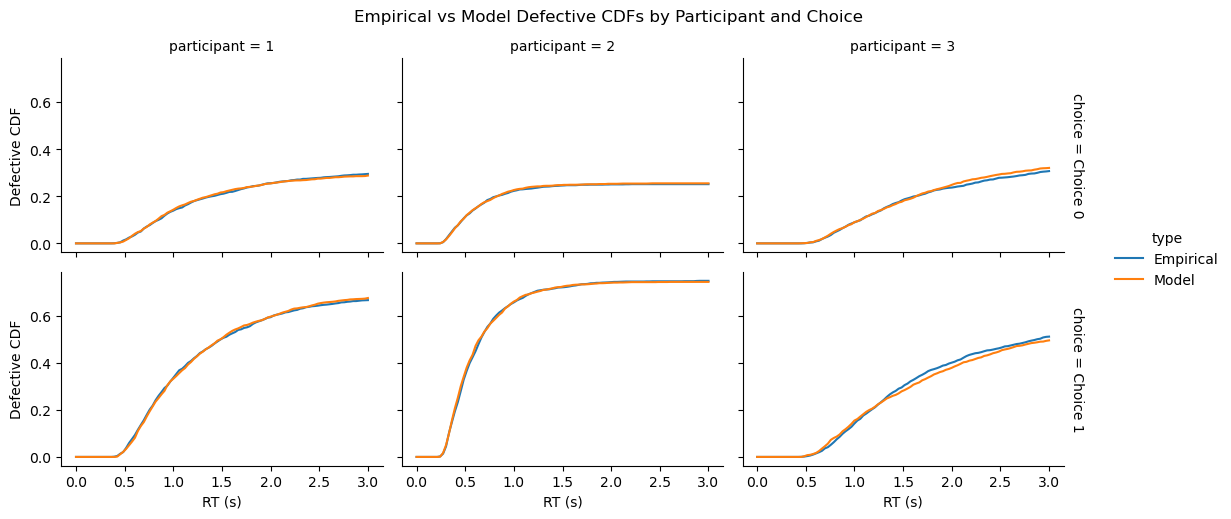

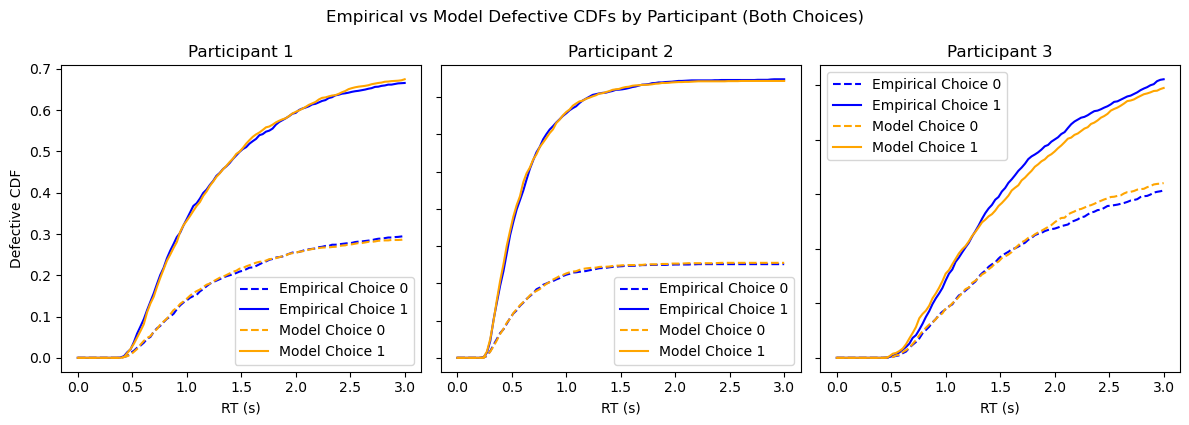

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyddm import Model, Fittable, Sample
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision

def defective_cdf(rt, choice, bins, target_choice):
    """Compute defective CDF for RTs for a specific choice, normalized by total trials."""
    valid = ~np.isnan(rt)
    rt = rt[valid]
    choice = choice[valid]
    total_trials = len(rt)
    mask = (choice == target_choice)
    rt_choice = rt[mask]
    # For each bin, count number of RTs for this choice &lt;= bin, then divide by total trials
    cdf = np.array([(rt_choice <= b).sum() / total_trials for b in bins])
    return cdf

fits = {}
for pid in df_all["participant"].unique():
    df_p = df_all[df_all["participant"] == pid]
    model = Model(
        drift=DriftConstant(drift=Fittable(minval=0.01, maxval=2)),
        noise=NoiseConstant(noise=1.0),
        bound=BoundConstant(B=Fittable(minval=0.3, maxval=2)),
        overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=0.5)),
        dx=.005, dt=.005, T_dur=15.0
    )
    model.fit(sample=Sample.from_pandas_dataframe(df_p, rt_column_name="RT", choice_column_name="choice"))
    fits[pid] = model

# Set up bins for CDF
rt_bins = np.linspace(0, 3, 100)  # Adjust as needed for your RT range

cdf_results = []
for pid, model_fitted in fits.items():
    df_p = df_all[df_all["participant"] == pid]
    sim = model_fitted.solve().resample(len(df_p))
    df_sim = sim.to_pandas_dataframe()
    for choice_val in [0, 1]:
        cdf_emp = defective_cdf(df_p["RT"].values, df_p["choice"].values, rt_bins, choice_val)
        cdf_sim = defective_cdf(df_sim["RT"].values, df_sim["choice"].values, rt_bins, choice_val)
        cdf_results.append(pd.DataFrame({
            "RT_bin": rt_bins,
            "cdf": cdf_emp,
            "type": "Empirical",
            "choice": f"Choice {choice_val}",
            "participant": pid
        }))
        cdf_results.append(pd.DataFrame({
            "RT_bin": rt_bins,
            "cdf": cdf_sim,
            "type": "Model",
            "choice": f"Choice {choice_val}",
            "participant": pid
        }))

df_cdf = pd.concat(cdf_results, ignore_index=True)

# Plot dCDFs for each participant, both choices in one panel
g = sns.FacetGrid(df_cdf, col="participant", hue="type", row="choice", height=2.5, aspect=1.5, margin_titles=True)
g.map(plt.plot, "RT_bin", "cdf")
g.add_legend()
g.set_axis_labels("RT (s)", "Defective CDF")
g.fig.suptitle("Empirical vs Model Defective CDFs by Participant and Choice", y=1.03)
plt.show()

# Alternatively, plot both choices in one panel per participant (using line style for choice)
df_cdf["line_style"] = df_cdf["choice"].map({"Choice 0": "dashed", "Choice 1": "solid"})
palette = {"Empirical": "blue", "Model": "orange"}
plt.figure(figsize=(12, 4))
for i, pid in enumerate(df_cdf["participant"].unique()):
    plt.subplot(1, len(df_cdf["participant"].unique()), i+1)
    df_sub = df_cdf[df_cdf["participant"] == pid]
    for (typ, choice), df_line in df_sub.groupby(["type", "choice"]):
        ls = "dashed" if choice == "Choice 0" else "solid"
        plt.plot(df_line["RT_bin"], df_line["cdf"], label=f"{typ} {choice}", color=palette[typ], linestyle=ls)
    plt.title(f"Participant {pid}")
    plt.xlabel("RT (s)")
    if i == 0:
        plt.ylabel("Defective CDF")
    else:
        plt.gca().set_yticklabels([])
    plt.legend()
plt.tight_layout()
plt.suptitle("Empirical vs Model Defective CDFs by Participant (Both Choices)", y=1.05)
plt.show()


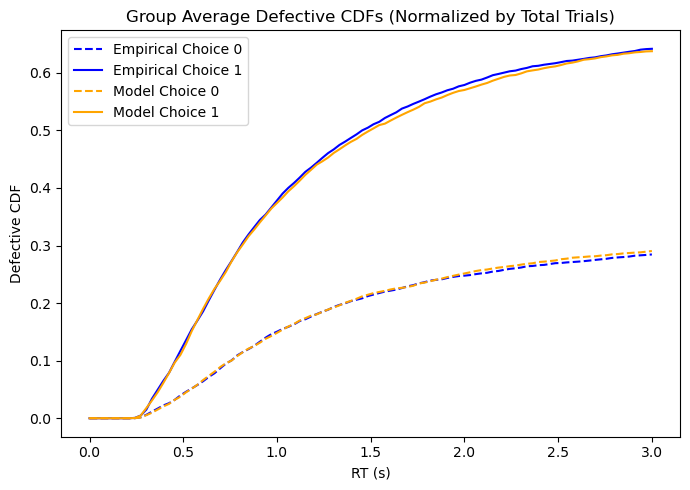

In [58]:
# Recompute cdf_results with corrected normalization
cdf_results = []
for pid, model_fitted in fits.items():
    df_p = df_all[df_all["participant"] == pid]
    sim = model_fitted.solve().resample(len(df_p))
    df_sim = sim.to_pandas_dataframe()
    for choice_val in [0, 1]:
        cdf_emp = defective_cdf(df_p["RT"].values, df_p["choice"].values, rt_bins, choice_val)
        cdf_sim = defective_cdf(df_sim["RT"].values, df_sim["choice"].values, rt_bins, choice_val)
        cdf_results.append(pd.DataFrame({
            "RT_bin": rt_bins,
            "cdf": cdf_emp,
            "type": "Empirical",
            "choice": f"Choice {choice_val}",
            "participant": pid
        }))
        cdf_results.append(pd.DataFrame({
            "RT_bin": rt_bins,
            "cdf": cdf_sim,
            "type": "Model",
            "choice": f"Choice {choice_val}",
            "participant": pid
        }))

df_cdf = pd.concat(cdf_results, ignore_index=True)

# Group average
df_cdf_group = (
    df_cdf
    .groupby(["RT_bin", "type", "choice"])["cdf"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(7, 5))
palette = {"Empirical": "blue", "Model": "orange"}
linestyles = {"Choice 0": "dashed", "Choice 1": "solid"}

for (typ, choice), df_line in df_cdf_group.groupby(["type", "choice"]):
    plt.plot(
        df_line["RT_bin"], df_line["cdf"],
        label=f"{typ} {choice}",
        color=palette[typ],
        linestyle=linestyles[choice]
    )

plt.xlabel("RT (s)")
plt.ylabel("Defective CDF")
plt.title("Group Average Defective CDFs (Normalized by Total Trials)")
plt.legend()
plt.tight_layout()
plt.show()


For further examples, see e.g.:

More examples of cumulative defective density plots:
- Figure 11 in:
Stevenson, N., Miletic, S., & Forstmann, B. (2025). Bridging Brain and Behavior: A Step-by-Step Tutorial to Joint Modeling with fMRI. OSF. https://doi.org/10.31234/osf.io/rhfk3_v1

Splits cumulative defective density plots by "confidence rating" (c.f. condition)




Roger Ratcliff uses a different type of plot: Quantile-probability plots. An example is shown in this book chapter, Figure 22.2:
- Ratcliff, R. (2012). Response time distributions. In H. Cooper, P. M. Camic, D. L. Long, A. T. Panter, D. Rindskopf, & K. J. Sher (Eds.), APA handbook of research methods in psychology, Vol 1: Foundations, planning, measures, and psychometrics. (pp. 429–443). American Psychological Association. https://doi.org/10.1037/13619-023

And Figure 2 here:
- Ratcliff, R., & Tuerlinckx, F. (2002). Estimating parameters of the diffusion model: Approaches to dealing with contaminant reaction times and parameter variability. Psychonomic Bulletin & Review, 9(3), 438–481.
